In [2]:
# This is needed to import the CC and EC Models from this location in this project.
import sys
sys.path.append("..")

from MagneticFluxRopeModels.ECModel import ECModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [18]:
df_wind = pd.read_csv("../event_data/wind/2005/12-13-june-2005.csv", sep=";")
df_wind = df_wind.drop("Year", axis=1)
df_wind = df_wind.rename(columns={"Bx": "B_x", "By": "B_y", "Bz": "B_z", "Vx": "v_x", "Vy": "v_y", "Vz": "v_z", "Btheta": "B_theta", "Bphi": "B_phi", "Np": "N_p"})
df_wind.head()

,DOY,millisecs,B,B_x,B_y,B_z,B_theta,B_phi,v_x,v_y,v_z,N_p
0,163,199031,7.14,1.05,-7.06,0.04,0.29,278.49,-300.4,-28.2,-18.9,19.3
1,163,297808,6.85,0.25,-6.71,1.22,10.28,272.17,-303.6,-28.3,-15.6,19.2
2,163,390506,6.63,-0.05,-6.47,1.45,12.61,269.55,-302.1,-28.1,-16.9,20.6
3,163,487763,6.57,-0.12,-6.43,1.29,11.33,268.97,-303.8,-28.8,-11.3,19.7
4,163,588094,6.44,-0.45,-6.14,1.87,16.86,265.84,-302.4,-28.2,-16.6,21.3


In [19]:
df_wind.tail()

,DOY,millisecs,B,B_x,B_y,B_z,B_theta,B_phi,v_x,v_y,v_z,N_p
1748,164,85950039,4.25,-4.15,-0.68,-0.37,-5.04,189.35,-448.9,-11.1,-2.0,5.2
1749,164,86049656,4.25,-3.11,-2.33,-1.18,-16.96,216.86,-459.9,19.8,-0.7,4.0
1750,164,86145375,4.40,-2.17,-3.37,-1.58,-21.54,237.20,-456.5,31.7,4.3,4.3
1751,164,86241812,4.46,-2.78,-3.09,-1.52,-20.04,227.97,-449.3,33.8,5.3,4.4
1752,164,86362632,4.54,-2.82,-2.95,-1.95,-25.50,226.28,-370.2,33.4,-287.1,12.0


In [20]:
SEC_TO_HOURS = 3600
SEC_TO_DAYS = 3600 * 24

df_wind["time_sec"] = df_wind["millisecs"] / 1000
df_wind = df_wind.drop("millisecs", axis=1)
df_wind["time_sec"] = df_wind["time_sec"] + (df_wind["DOY"] - df_wind["DOY"][0])*(SEC_TO_DAYS)
df_wind["time_days"] = df_wind["time_sec"] / SEC_TO_DAYS

In [21]:
df_event = df_wind.loc[(df_wind["time_days"] >= 0.63) & (df_wind["time_days"] <= 1.75)]
df_event = df_event.reset_index(drop=True)
df_event["time"] = df_event["time_sec"] - df_event["time_sec"][0]
df_wind.head()

,DOY,B,B_x,B_y,B_z,B_theta,B_phi,v_x,v_y,v_z,N_p,time_sec,time_days
0,163,7.14,1.05,-7.06,0.04,0.29,278.49,-300.4,-28.2,-18.9,19.3,199.031,0.002304
1,163,6.85,0.25,-6.71,1.22,10.28,272.17,-303.6,-28.3,-15.6,19.2,297.808,0.003447
2,163,6.63,-0.05,-6.47,1.45,12.61,269.55,-302.1,-28.1,-16.9,20.6,390.506,0.004520
3,163,6.57,-0.12,-6.43,1.29,11.33,268.97,-303.8,-28.8,-11.3,19.7,487.763,0.005645
4,163,6.44,-0.45,-6.14,1.87,16.86,265.84,-302.4,-28.2,-16.6,21.3,588.094,0.006807


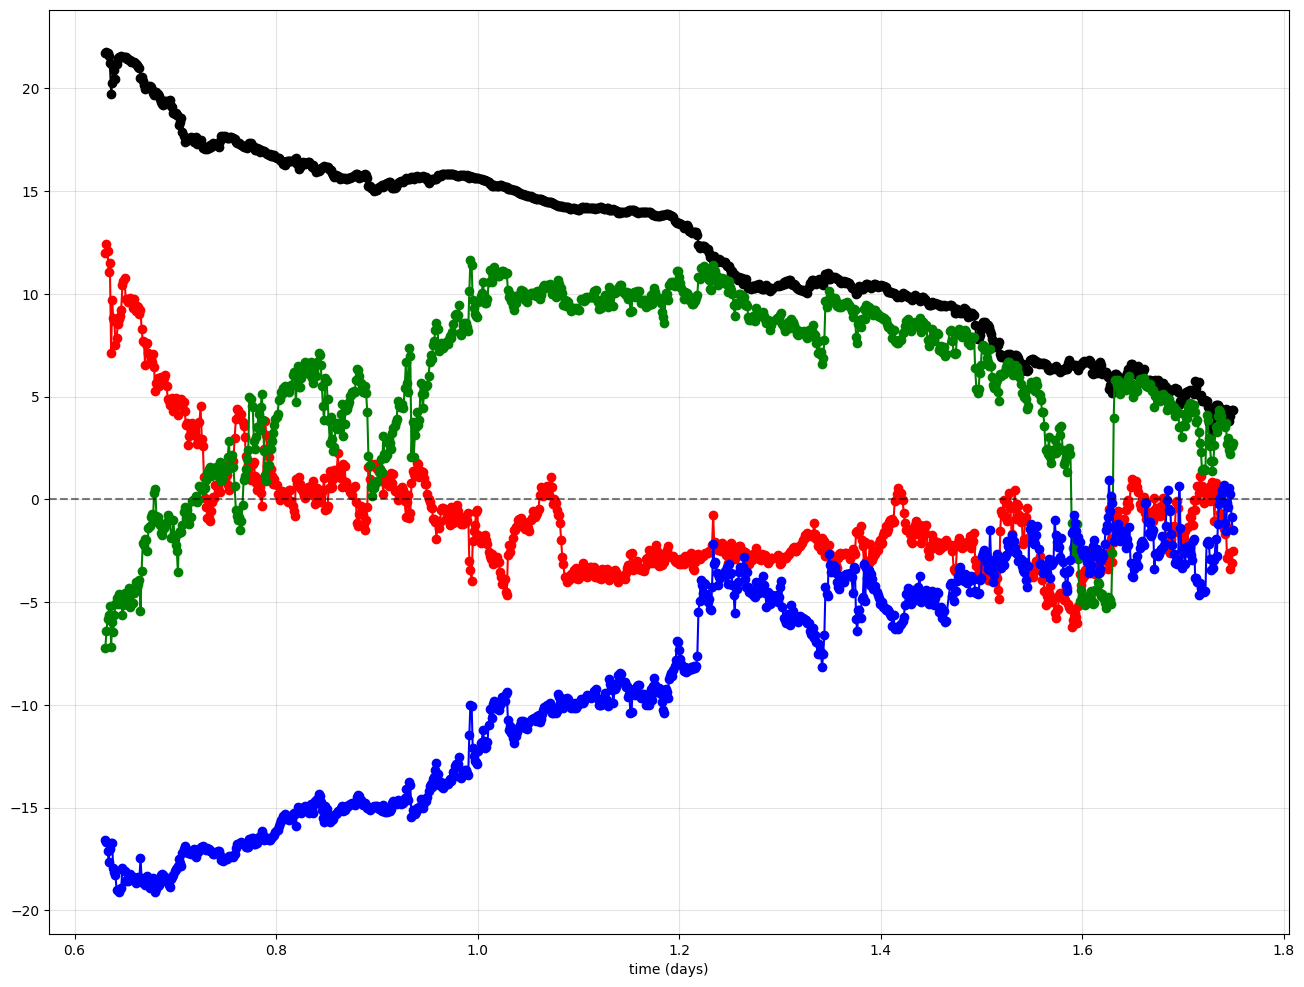

In [22]:
def plot_event(df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.plot(df["time_days"], df["B"], "-ok")
    ax.plot(df["time_days"], df["B_x"], "-or")
    ax.plot(df["time_days"], df["B_y"], "-og")
    ax.plot(df["time_days"], df["B_z"], "-ob")
    ax.axhline(0, linestyle="--", color="k", alpha=0.5)
    ax.set_xlabel("time (days)")
    ax.grid(alpha=0.35)

plot_event(df_event)

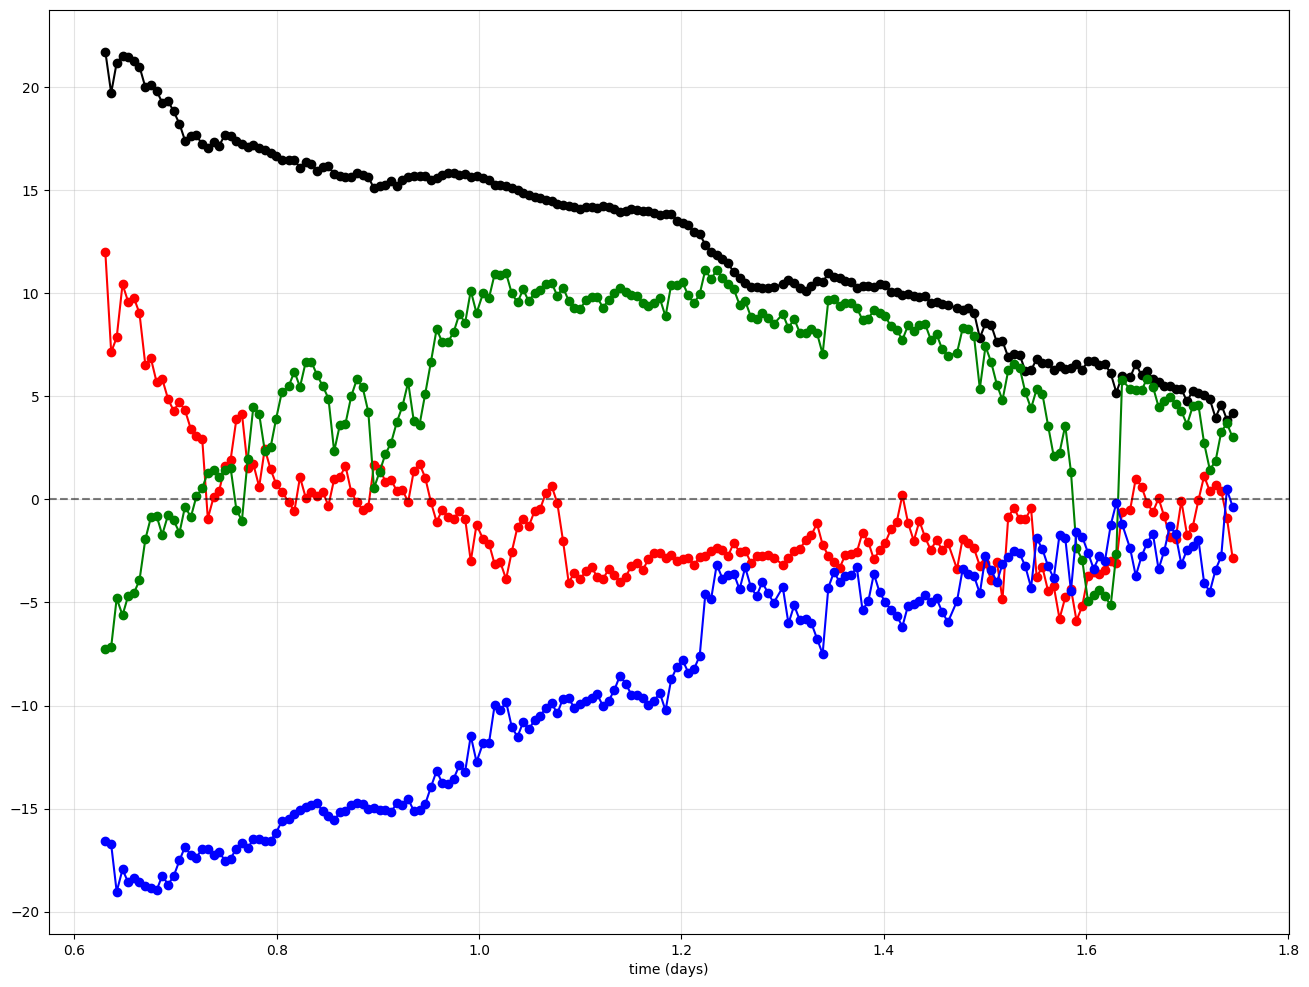

In [24]:
DOWN_SAPLING_FACTOR = 5
df_event_reduced = df_event.loc[list(range(0, len(df_event), DOWN_SAPLING_FACTOR))]
plot_event(df_event_reduced)

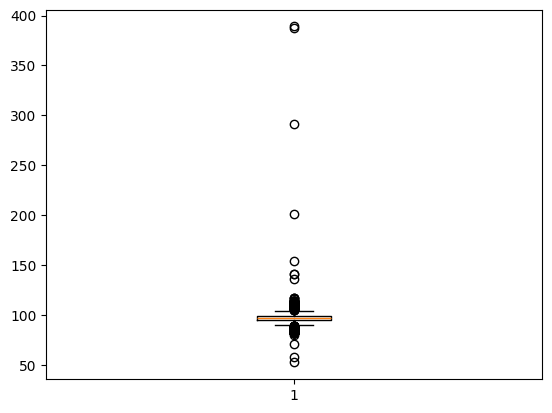

In [25]:
df_event_filtered = df_event.reset_index(drop=True)
plt.boxplot(np.diff(df_event_filtered["time"]))
plt.show()

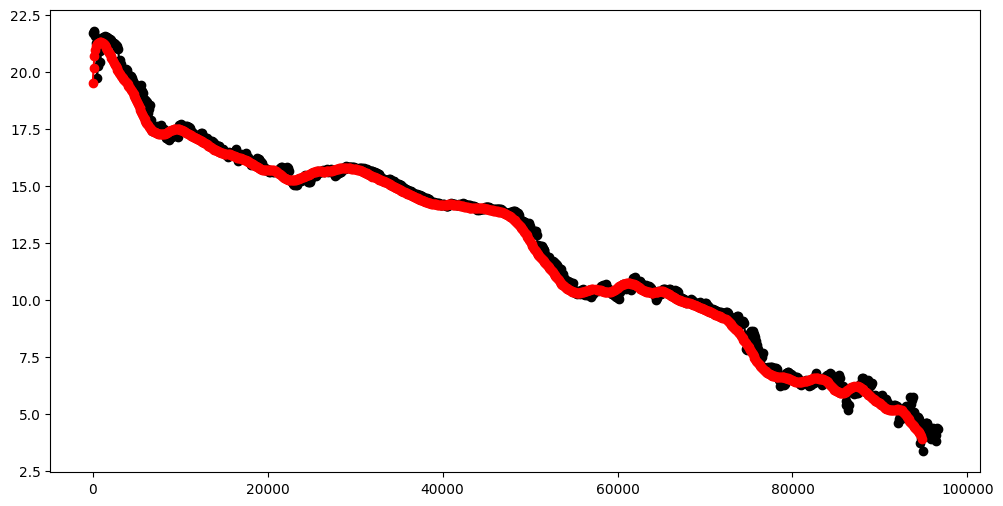

In [ ]:
def moving_average(x, window_size=12):
    return np.convolve(x, np.ones(window_size)/window_size, mode="valid")

B_filtered = moving_average(df_event_filtered["B"], window_size=20)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(df_event["time"], df_event["B"], "-ok")
plt.plot(df_event_filtered["time"][0 : len(B_filtered)], B_filtered, "-or")

In [ ]:
model_params = {
    "delta": {"mode": "fixed", "value": 1.0},
    #"delta": {"mode": "optimised", "initial_value": 0.8, "bounds": [0.2, 1]},
    "psi": {"mode": "fixed", "value": 0},
    # "psi": {"mode": "optimised", "initial_value": math.radians(45), "bounds": [0.01, math.radians(180)*0.99]},
    "tau": {"mode": "optimised", "initial_value": 1.4, "bounds": [0.1, 2.0]},
    "C_nm": {"mode": "optimised", "initial_value": 1.4, "bounds": [0.15, 3]},
    "B_z_0": {"mode": "optimised", "initial_value": 15.0, "bounds": [5, 25]}
    }

crossing_params = {
    "y_0": {"mode": "optimised", "initial_value": 0.0, "bounds": [-0.95, 0.95]},
    "v_sc": {"mode": "fixed", "value": 480.0},
    "theta": {"mode": "optimised", "initial_value": math.radians(0), "bounds": [-math.radians(89), math.radians(89)]},
    }
result = ECModel.fit(ECModel, df_event, model_params, crossing_params, residue_method="X")

result[0]
result[1]
result[2]
result[3]

{'grad': array([-0.15855566, -0.01801279,  0.0019778 ,  0.07894094,  0.02132232]),
 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'funcalls': 252,
 'nit': 25,
 'warnflag': 0,
 'x_opt': array([ 0.5314665 ,  2.98197882, 10.41030484,  0.89832056,  0.64957932]),
 'f_opt': 9.48507911626843}

In [34]:
result[0]

ECModel with parameters:
        - Geometrical:
            - delta = 1.000
            - psi = 0.000 deg
            - R = 0.050 AU
        - Field:
            - n = 1
            - m = 0
            - tau = 0.531
            - C_nm = 2.982
            - B_z_0 = 10.410 nT
            - handedness = 1.

In [37]:
result[1]

{'y_0': np.float64(0.95),
 'theta': np.float64(1.1147958561655644),
 'v_sc': 480.0,
 'time_stencil': array([0.0000000e+00, 9.4215000e+01, 1.9147200e+02, 2.8787100e+02,
        3.8902700e+02, 4.9838600e+02, 5.8348400e+02, 6.7385900e+02,
        7.7415600e+02, 8.7141400e+02, 9.6867200e+02, 1.0659290e+03,
        1.1631870e+03, 1.2604410e+03, 1.3576990e+03, 1.4687730e+03,
        1.5530190e+03, 1.6472930e+03, 1.7436910e+03, 1.8439840e+03,
        1.9442810e+03, 2.0415390e+03, 2.1387970e+03, 2.2360540e+03,
        2.3333120e+03, 2.4443860e+03, 2.5278240e+03, 2.6250820e+03,
        2.7223390e+03, 2.8195970e+03, 2.9168550e+03, 3.0149720e+03,
        3.1091290e+03, 3.2079650e+03, 3.3052220e+03, 3.4160860e+03,
        3.5042970e+03, 3.5954760e+03, 3.6972180e+03, 3.7937930e+03,
        3.8902850e+03, 3.9875430e+03, 4.0817610e+03, 4.1759100e+03,
        4.2755230e+03, 4.3848280e+03, 4.4738280e+03, 4.5671870e+03,
        4.6653040e+03, 4.7603240e+03, 4.8589610e+03, 4.9562150e+03,
        5.053472

Text(0.5, 0, 'time (s)')

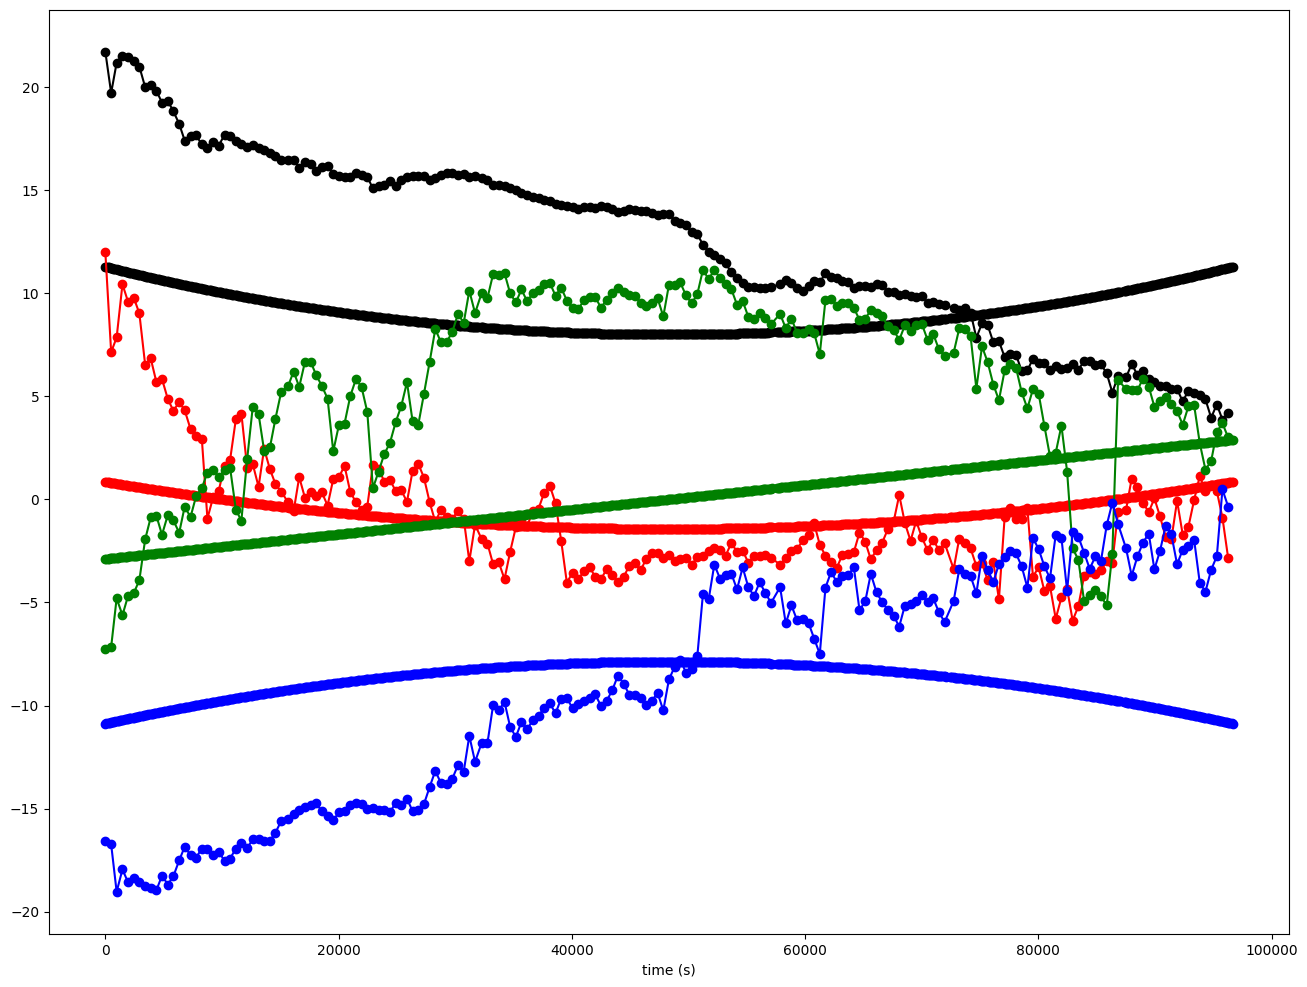

In [35]:
df_fitted = result[2]

fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(df_event_reduced["time"], df_event_reduced["B"], "-ok")
ax.plot(df_fitted["time"], df_fitted["B"], "--ok")

ax.plot(df_event_reduced["time"], df_event_reduced["B_x"], "-or")
ax.plot(df_fitted["time"], df_fitted["B_x"], "--or")

ax.plot(df_event_reduced["time"], df_event_reduced["B_y"], "-og")
ax.plot(df_fitted["time"], df_fitted["B_y"], "--og")

ax.plot(df_event_reduced["time"], df_event_reduced["B_z"], "-ob")
ax.plot(df_fitted["time"], df_fitted["B_z"], "--ob")
ax.set_xlabel("time (s)")

# plt.plot(df_fitted["time"], df_fitted["B"], "-ok")
# plt.plot(df_fitted["time"], df_fitted["B_x"], "-or")
# plt.plot(df_fitted["time"], df_fitted["B_y"], "-og")
# plt.plot(df_fitted["time"], df_fitted["B_z"], "-ob")